# DRAG
> @author: Jiheng Duan

## About

This document will tell you how to scan add DRAG transform on the existing pulse, and how to scan the corresponding coefficients.

### Required Import

**The following thing must be import.**

In the current folder (despite `~\Tutorial\arb_qubit_tutorial\`), the system structure are based on file `~\System\transmon_system.py`. For using arbitrary qubit system structure, please move to the demonstration file under `~\Tutorial\arb_qubit_tutorial\`.

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import sys
# This on is a path correcting code, which is used to find the path of QuSim.
sys.path.append('../..')

import QuSim.System.transmon_system as qs
# Some useful tools
import QuSim.Instruments.tools as tools
# Some intrinsic plotting function
import QuSim.DataPlot.plot_lib as pl
import QuSim.PulseGen.pulse_waveform as pw

# variable name -> string
def var_name2str(variable):
    def nested_var_name2str(value):
        if isinstance(value, list):
            return [nested_var_name2str(item) for item in value]
        else:
            for name in globals():
                if eval(name) == value:
                    return name
            return str(value)
    return nested_var_name2str(variable)

### Optional import

**The following import are optional**

In [2]:
# Print the full output
np.set_printoptions(threshold=sys.maxsize)

# auto reload
%load_ext autoreload
%autoreload 2 

## DRAG regime
Assume the driving pulse has shape $\Omega(t) \in \mathbb{Z}$. The pulse in derivative reduction by adiabatic gate (DRAG) regime is define by
$$
\Omega'(t) = \Omega(t) - i \lambda \frac{\dot{\Omega}(t)}{\Delta},
$$
where $\lambda$ is the DRAG scaling parameter, $\alpha$ is the anharmonicity given by $\alpha = \omega_q^{1\rightarrow 2} - \omega_q$.

After apply DRAG, and additional phase correction is required by taking the DRAG pulse into a new pulse $\Omega''(t)$ as
$$
\Omega''(t) = \Omega'(t) e^{i2\pi \delta f (t- t_0)}
$$
where $\delta f$ is a pulse frequency detuning parameter and $t_0$ is the center position of the pulse.

If we add an additional pulse detuning correction to the microwave, we should redefine the anharmonicity used in the DRAG correction by replacing $\alpha$ by $\Delta $:
$$
\Omega'(t) = \Omega(t) - i \lambda \frac{\dot{\Omega}(t)}{\Delta},
$$

In our code, the DRAG regime can be turned on for `'XY'` pulses, which can be added in `pulse_sequence`. The correspondences are:
>* $\lambda$: `'DRAG_scale'`
>* $\Delta$: `'DRAG_delta'`
>* $\delta f$: ``'pulse_detuning'``

Notice that the protocol here allows the user to input a list of `'DRAG_scale'` and `'DRAG_delta'` to achieve multiple DRAG on a single pulse.

### How to setup DRAG?
#### Setup system

In [29]:
N = None
w = [6.3] # Qubit frequency
q_dim = [3 for _ in range(len(w))] # Dimension of each qubit
alpha =[-0.3] # Anharmonicity
r=  0
gamma_list = None

# Set up system class
_system = qs.qubit_system(N, q_dim, w, alpha, r, gamma_list)

state_0, E_0, index_0 = _system.get_eigenstates_energy((0,))
state_1, E_1, index_1 = _system.get_eigenstates_energy((1,))
state_2, E_2, index_2 = _system.get_eigenstates_energy((2,))

simulation_option = {
    "simulation_time": 30, # ns
    "simulation_step": 15000,
    "initial_state": [qs.ket2dm(state_0)] # Do multiple simulation
}

#### Define Pulse sequence with DRAG

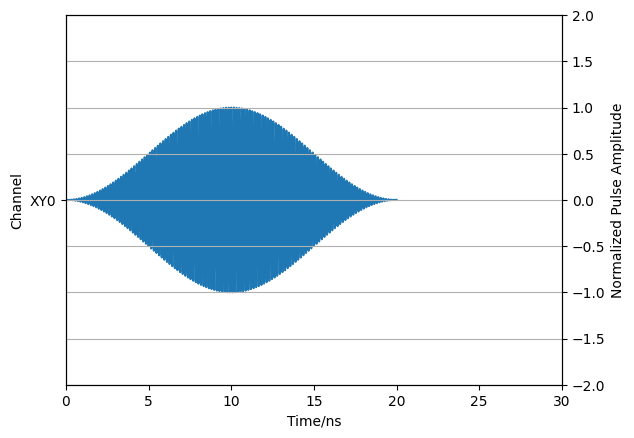

0

In [30]:
pulse_sequence = [
    {
        'pulse_index': 1,
        'type': "XY",
        'pulse_shape': "cosine",
        't_delay': 0, # unit in ns
        't_width': 20, # unit in ns
        't_plateau': 0, # unit in ns
        'freq': 6.3, # Carrier frequency, unit in GHz;
        'phase': 0, # Carrier phase, unit in rad
        'amplitude': 0.05, # XY: Rabi freq; Z: biased frequency
        'q_index': 0, # 0, 1, 2 ...
        'DRAG_scale': 1, # DRAG scale, ranges in [0,1]
        'DRAG_delta': -0.3, # DRAG detuning \Delta
        'pulse_detuning': 0.001688 # Pulse detuning correction, unit in GHz
    }
]

pl.plot_pulse_sequence(pulse_sequence, simulation_option)

#### Do system dynamics and plot the result

In [31]:
result_list, angle_list = _system.system_dynamics_mesolve(simulation_option, pulse_sequence)

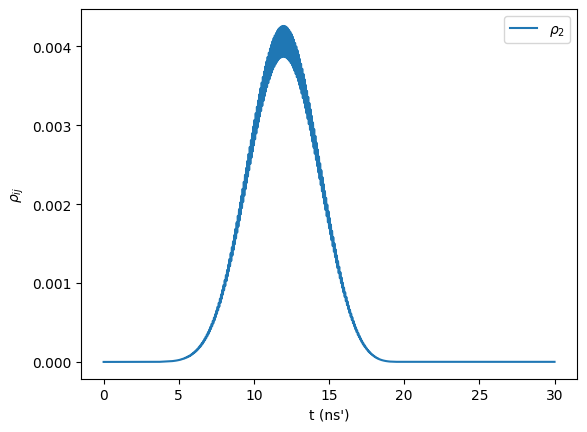

In [32]:
t = np.linspace(0, simulation_option['simulation_time'], simulation_option['simulation_step'])

# Select which result you want to see
result = result_list[0]

# Plot
%matplotlib inline

# plt.plot(t,qs.expect(result.states, state_0 * qs.dag(state_0)), label=r'$\rho_{0}$');
# plt.plot(t,qs.expect(result.states, state_1 * qs.dag(state_1)), label=r'$\rho_{1}$');
plt.plot(t,qs.expect(result.states, state_2 * qs.dag(state_2)), label=r'$\rho_{2}$');
plt.ylabel(r"$\rho_{ij}$")
plt.xlabel("t (ns')")
plt.legend()
plt.show()

### Multiple DRAG case

In [ ]:
pulse_sequence = [
    {
        'pulse_index': 1,
        'type': "XY",
        'pulse_shape': "cosine",
        't_delay': 0, # unit in ns
        't_width': 20, # unit in ns
        't_plateau': 0, # unit in ns
        'freq': 6.3, # Carrier frequency, unit in GHz;
        'phase': 0, # Carrier phase, unit in rad
        'amplitude': 0.04, # XY: Rabi freq; Z: biased frequency
        'q_index': 0, # 0, 1, 2 ...
        'DRAG_scale': [0.2, 1, 0.3, 1], # DRAG scale, ranges in [0,1]
        'DRAG_delta': [-0.3, -0.2, -0.4, -0.5], # DRAG detuning \Delta
        'pulse_detuning': 0.001688 # Pulse detuning correction, unit in GHz
    }
]

pl.plot_pulse_sequence(pulse_sequence, simulation_option)

### Scanning DRAG parameter

In this section, we will show you how to scan the DRAG parameter, including `'DRAG_scale'`, `'DRAG_delta'`, and `'pulse_detuning'`.

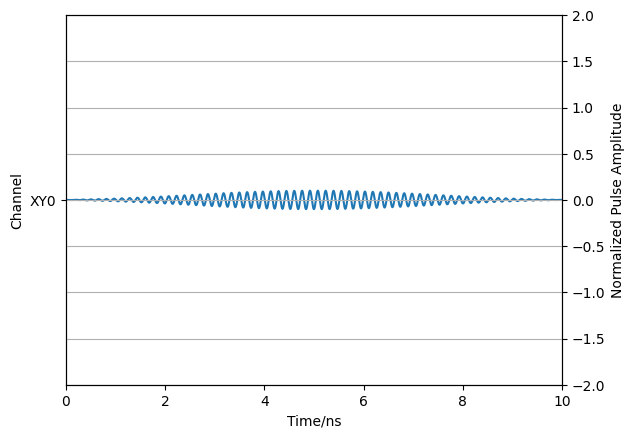

0

In [34]:
N = None
w = [6.3] # Qubit frequency
q_dim = [3 for _ in range(len(w))] # Dimension of each qubit
alpha =[-0.3] # Anharmonicity
r = 0
gamma_list = None

# Set up system class
_system = qs.qubit_system(N, q_dim, w, alpha, r, gamma_list)

state_0, E_0, index_0 = _system.get_eigenstates_energy((0,))
state_1, E_1, index_1 = _system.get_eigenstates_energy((1,))
state_2, E_2, index_2 = _system.get_eigenstates_energy((2,))

simulation_option = {
    "simulation_time": 10, # ns
    "simulation_step": 100000,
    "initial_state": [qs.ket2dm(state_0)] # Do multiple simulation
}
pulse_sequence = [
    {
        'pulse_index': 1,
        'type': "XY",
        'pulse_shape': "cosine",
        't_delay': 0, # unit in ns
        't_width': 10, # unit in ns
        't_plateau': 0, # unit in ns
        'freq': 6.3, # Carrier frequency, unit in GHz;
        'phase': 0, # Carrier phase, unit in rad
        'amplitude': 0.1, # XY: Rabi freq; Z: biased frequency
        'q_index': 0, # 0, 1, 2 ...
        'DRAG_scale': 1, # DRAG scale, ranges in [0,1]
        'DRAG_delta': -0.2766917293, # DRAG detuning \Delta
        'pulse_detuning': 0.0037593985 # Pulse detuning correction, unit in GHz
    }
]

pl.plot_pulse_sequence(pulse_sequence, simulation_option)

#### Before DRAG

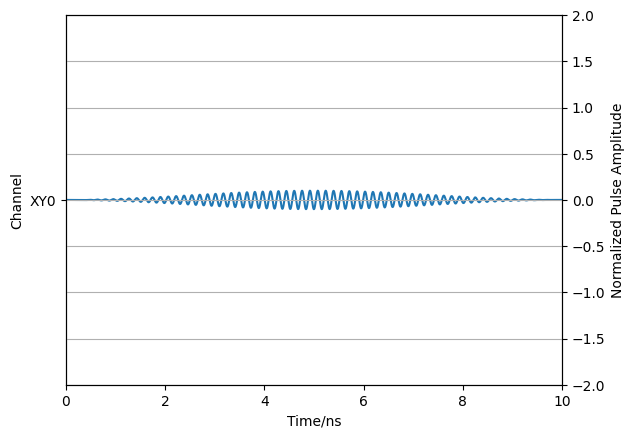

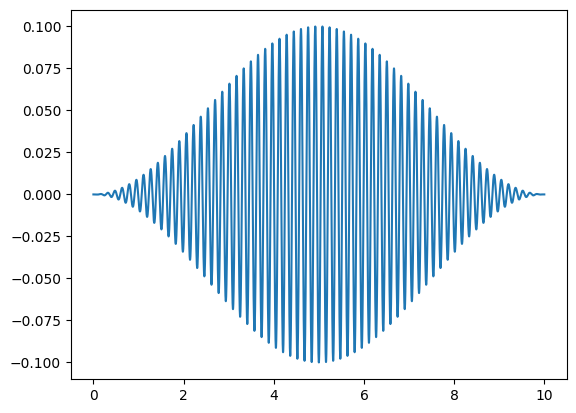

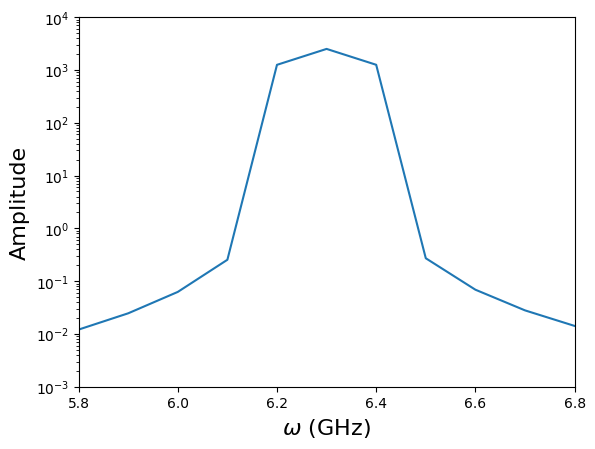

In [48]:
pulse_sequence_noDRAG = [
    {
        'pulse_index': 1,
        'type': "XY",
        'pulse_shape': "cosine",
        't_delay': 0, # unit in ns
        't_width': 10, # unit in ns
        't_plateau': 0, # unit in ns
        'freq': 6.3, # Carrier frequency, unit in GHz;
        'phase': 0, # Carrier phase, unit in rad
        'amplitude': 0.1, # XY: Rabi freq; Z: biased frequency
        'q_index': 0
    }
]
pl.plot_pulse_sequence(pulse_sequence_noDRAG, simulation_option)

tlist = np.linspace(0, simulation_option['simulation_time'], simulation_option['simulation_step'], endpoint=False)
freqlist = np.fft.fftfreq(simulation_option['simulation_step'], d=tlist[1]-tlist[0])

pulse_lib_c = pw.pulse_lib(pulse_sequence_noDRAG[0])
drive_pulse = pulse_lib_c.get_pulse(simulation_option)

plt.figure(1)
plt.plot(tlist, drive_pulse)
fft_waveform_noDRAG = np.fft.fft(drive_pulse)
plt.figure(2)
plt.plot(freqlist, np.abs(fft_waveform_noDRAG))
plt.xlim([5.8,6.8])
plt.ylim(1e-3,1e4)
plt.ylabel('Amplitude', fontsize=16)
plt.xlabel(r"$\omega$ (GHz)", fontsize=16)
plt.yscale('log')

#### Test DRAG

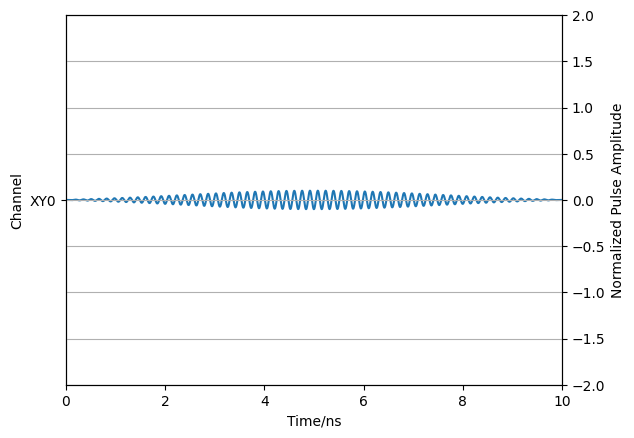

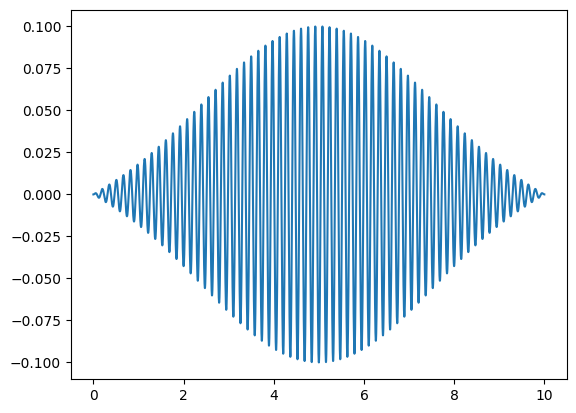

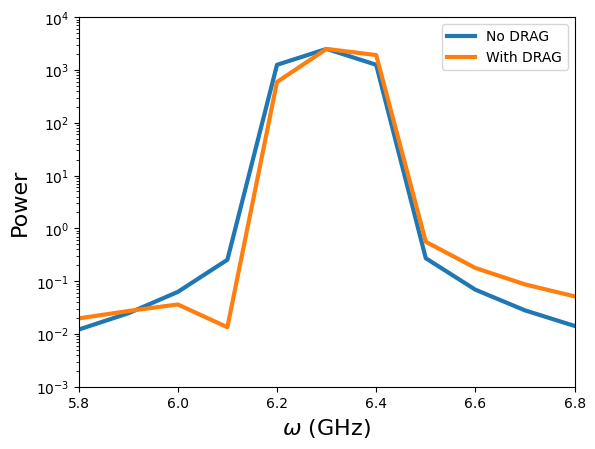

In [59]:
pulse_sequence_withDRAG = [
    {
        'pulse_index': 1,
        'type': "XY",
        'pulse_shape': "cosine",
        't_delay': 0, # unit in ns
        't_width': 10, # unit in ns
        't_plateau': 0, # unit in ns
        'freq': 6.3, # Carrier frequency, unit in GHz;
        'phase': 0, # Carrier phase, unit in rad
        'amplitude': 0.1, # XY: Rabi freq; Z: biased frequency
        'q_index': 0
        , # 0, 1, 2 ...
        'DRAG_scale': 1, # DRAG scale, ranges in [0,1]
        'DRAG_delta': -0.19
        , # DRAG detuning \Delta
        # 'pulse_detuning': 0.0037593985 # Pulse detuning correction, unit in GHz
    }
]
pl.plot_pulse_sequence(pulse_sequence_withDRAG, simulation_option)

tlist = np.linspace(0, simulation_option['simulation_time'], simulation_option['simulation_step'], endpoint=False)
freqlist = np.fft.fftfreq(simulation_option['simulation_step'], d=tlist[1]-tlist[0])

pulse_lib_c = pw.pulse_lib(pulse_sequence_withDRAG[0])
drive_pulse = pulse_lib_c.get_pulse(simulation_option)

plt.figure(1)
plt.plot(tlist, drive_pulse)
fft_waveform_withDRAG = np.fft.fft(drive_pulse)
plt.figure(2)
plt.plot(freqlist, np.abs(fft_waveform_noDRAG), label="No DRAG", linewidth=3)
plt.plot(freqlist, np.abs(fft_waveform_withDRAG), label="With DRAG", linewidth=3)

plt.xlim([5.8,6.8])
plt.ylim(1e-3,1e4)
plt.ylabel('Power', fontsize=16)
plt.xlabel(r"$\omega$ (GHz)", fontsize=16)
plt.legend()
plt.yscale('log')

In [131]:
result_list, angle_list = _system.system_dynamics_mesolve(simulation_option, pulse_sequence)

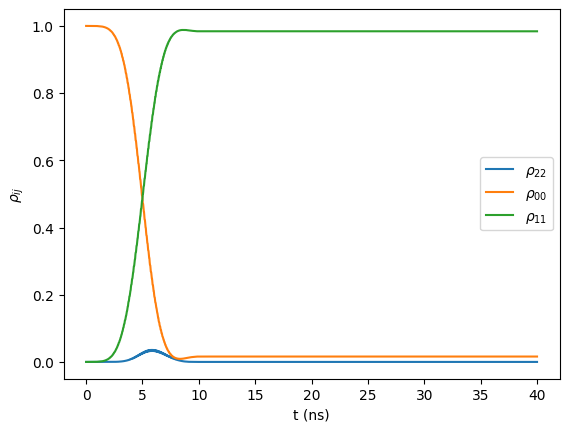

In [132]:
t = np.linspace(0, simulation_option['simulation_time'], simulation_option['simulation_step'])

# Select which result you want to see
result = result_list[0]

# Plot
%matplotlib inline

plt.plot(t,qs.expect(result.states, state_2 * qs.dag(state_2)), label=r'$\rho_{22}$');
plt.plot(t,qs.expect(result.states, state_0 * qs.dag(state_0)), label=r'$\rho_{00}$');
plt.plot(t,qs.expect(result.states, state_1 * qs.dag(state_1)), label=r'$\rho_{11}$');
plt.ylabel(r"$\rho_{ij}$")
plt.xlabel("t (ns)")
plt.legend()
plt.show()

In [134]:
qs.expect(result.states, state_1 * qs.dag(state_1))[-1]

0.9839941318183911

#### DRAG Scale scan

In [120]:
# Define the range you want to scan
DRAG_scale_scan = np.linspace(0,1, 200)
# Copy your pulse sequence list
pulse_sequence_scan = list(np.copy(pulse_sequence))

result_collection = []
for i, scale in enumerate(DRAG_scale_scan):
    pulse_sequence_scan[0]['DRAG_scale'] = scale
    result_list, angle_list = _system.system_dynamics_mesolve(simulation_option, pulse_sequence_scan)
    result_collection.append(result_list)

Minimum leakage = 3.430540163514211e-06, corresponding DRAG scale = 1.0


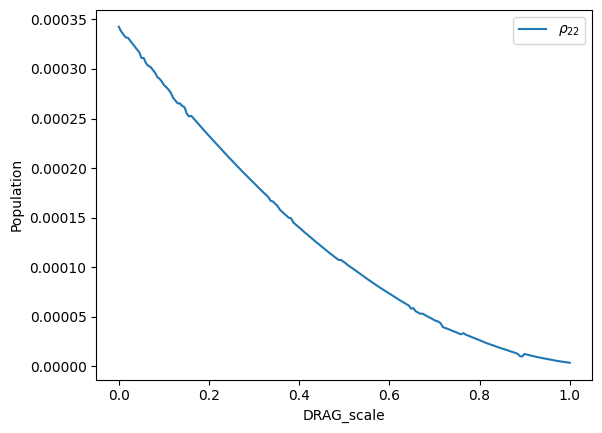

In [121]:
p0_max, p1_max, p2_max = [], [], []

for k, DRAG_scaling in enumerate(DRAG_scale_scan):
    p2_max.append(qs.expect(result_collection[k][0].states, state_2 * qs.dag(state_2))[-1])
    p1_max.append(qs.expect(result_collection[k][0].states, state_1 * qs.dag(state_1))[-1])
    p0_max.append(qs.expect(result_collection[k][0].states, state_0 * qs.dag(state_0))[-1])
plt.plot(DRAG_scale_scan, p2_max, label=r'$\rho_{22}$')
# plt.plot(DRAG_scale_scan, p1_max, label='$\rho_{11}$')
# plt.plot(DRAG_scale_scan, p0_max, label='$\rho_{00}$')
plt.legend()
plt.xlabel('DRAG_scale')
plt.ylabel('Population')
min_index = np.argmin(np.array(p2_max))
print(f"Minimum leakage = {p2_max[min_index]}, corresponding DRAG scale = {DRAG_scale_scan[min_index]}")

#### DRAG delta scan

In [124]:
# Define the range you want to scan
DRAG_delta_scan = np.linspace(-0.4,-0.1, 400)
# Copy your pulse sequence list
pulse_sequence_scan = list(np.copy(pulse_sequence))

result_collection = []
for i, delta in enumerate(DRAG_delta_scan):
    pulse_sequence_scan[0]['DRAG_delta'] = delta
    result_list, angle_list = _system.system_dynamics_mesolve(simulation_option, pulse_sequence_scan)
    result_collection.append(result_list)

Minimum leakage = -1.956816139190032e-06, corresponding DRAG delta = -0.27669172932330827


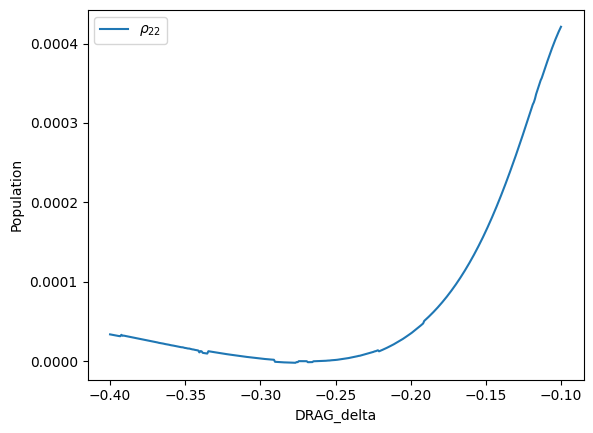

In [125]:
p0_max, p1_max, p2_max = [], [], []
ss = simulation_option["simulation_step"]-1

for k, DRAG_scaling in enumerate(DRAG_delta_scan):
    p2_max.append(qs.expect(result_collection[k][0].states, state_2 * qs.dag(state_2))[-1])
    p1_max.append(qs.expect(result_collection[k][0].states, state_1 * qs.dag(state_1))[-1])
    p0_max.append(qs.expect(result_collection[k][0].states, state_0 * qs.dag(state_0))[-1])
plt.plot(DRAG_delta_scan, p2_max, label=r'$\rho_{22}$')
# plt.plot(DRAG_delta_scan, p1_max, label=r'$\rho_{11}$')
# plt.plot(DRAG_delta_scan, p0_max, label=r'$\rho_{00}$')
plt.legend()
plt.xlabel('DRAG_delta')
plt.ylabel('Population')
min_index = np.argmin(np.array(p2_max))
print(f"Minimum leakage = {p2_max[min_index]}, corresponding DRAG delta = {DRAG_delta_scan[min_index]}")

#### Pulse detuning scan

In [127]:
# Define the range you want to scan
pulse_detuning_scan = np.linspace(-0.1,0.1, 400)
# Copy your pulse sequence list
pulse_sequence_scan = list(np.copy(pulse_sequence))

result_collection = []
for i, detuning in enumerate(pulse_detuning_scan):
    pulse_sequence_scan[0]['pulse_detuning'] = detuning
    result_list, angle_list = _system.system_dynamics_mesolve(simulation_option, pulse_sequence_scan)
    result_collection.append(result_list)

Minimum leakage = -2.306927357345647e-06, corresponding pulse detuning = 0.0037593984962406013


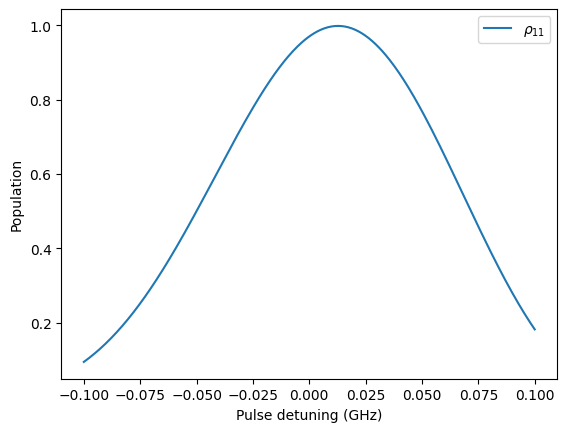

In [128]:
p0_max, p1_max, p2_max = [], [], []
ss = simulation_option["simulation_step"]-1

for k, DRAG_scaling in enumerate(pulse_detuning_scan):
    p2_max.append(qs.expect(result_collection[k][0].states, state_2 * qs.dag(state_2))[-1])
    p1_max.append(qs.expect(result_collection[k][0].states, state_1 * qs.dag(state_1))[-1])
    p0_max.append(qs.expect(result_collection[k][0].states, state_0 * qs.dag(state_0))[-1])
# plt.plot(pulse_detuning_scan, p2_max, label=r'$\rho_{22}$')
plt.plot(pulse_detuning_scan, p1_max, label=r'$\rho_{11}$')
# plt.plot(pulse_detuning_scan, p0_max, label=r'$\rho_{00}$')
plt.legend()
plt.xlabel('Pulse detuning (GHz)')
plt.ylabel('Population')
min_index = np.argmin(np.array(p2_max))
print(f"Minimum leakage = {p2_max[min_index]}, corresponding pulse detuning = {pulse_detuning_scan[min_index]}")